# Tmall Data Anlysis

## Data and Purpose

### Data

This dataset collected a total of 28,010 pieces of data that occurred in one month, including the following:

- Order number(订单编号): Order number
- Total amount(总金额): total amount of the order
- Amount actually paid by the buyer(买家实际支付金额): Total amount - refund amount (in case of payment). The amount is 0 (in case of non-payment)
- Delivery address(收货地址): each province
- Order creation time(订单创建时间): Order time
- Order payment time(订单付款时间) Payment time
- Refund amount(退款金额): The amount requested for a refund after payment. If no payment has been made, the refund amount is 0

### Purpose

- Conversion rate of each link of the order
- Order closing time (by day) Trend (by actual closing)
- Distribution of orders on a map

## Data Processing

### Read in data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('tmall_order_report.csv')

In [3]:
df.head(1)

,订单编号,总金额,买家实际支付金额,收货地址,订单创建时间,订单付款时间,退款金额
0,1,178.8,0.0,上海,2020-02-21 00:00:00,NaN,0.0


In [4]:
df.tail(1)

,订单编号,总金额,买家实际支付金额,收货地址,订单创建时间,订单付款时间,退款金额
28009,28010,37.0,37.0,广东省,2020-02-27 00:00:06,2020-02-27 00:00:11,0.0


### Processing

In [5]:
df.columns

Index(['订单编号', '总金额', '买家实际支付金额', '收货地址 ', '订单创建时间', '订单付款时间 ', '退款金额'], dtype='object')

There is whitespace in the column name. Rename column names so to remove the whitespaces.

In [6]:
df = df.rename( columns = {'收货地址 ':'收货地址','订单付款时间 ':'订单付款时间'} )
df.columns

Index(['订单编号', '总金额', '买家实际支付金额', '收货地址', '订单创建时间', '订单付款时间', '退款金额'], dtype='object')

Now, whitespaces have all gone. Let's check the basic information.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28010 entries, 0 to 28009
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   订单编号      28010 non-null  int64  
 1   总金额       28010 non-null  float64
 2   买家实际支付金额  28010 non-null  float64
 3   收货地址      28010 non-null  object 
 4   订单创建时间    28010 non-null  object 
 5   订单付款时间    24087 non-null  object 
 6   退款金额      28010 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 1.5+ MB


Let's check if there is dupliated rows.

In [9]:
df.duplicated().sum()

0

Let's check if there is any missing values.

In [10]:
df.isnull().sum()

订单编号           0
总金额            0
买家实际支付金额       0
收货地址           0
订单创建时间         0
订单付款时间      3923
退款金额           0
dtype: int64

Obvisouly, there are missing values in Order payment time(订单付款时间).

## Conversion rate - Funnel plot

### Some basic information

In [20]:
dict_convs = dict()

#### Total order number

In [21]:
key = 'Total Order Number'
dict_convs[key] = len(df)
len(df)

28010

#### The number of paid orders

In [22]:
key = 'Paid Orders'
# Paid if order payment time is not null
df_payed = df[df['订单付款时间'].notnull()]
dict_convs[key] = len(df_payed)
len(df_payed)

24087

#### The number of payment received

In [23]:
key = 'Payment Received'
# 买家实际支付金额：总金额 - 退款金额（在已付款的情况下）
# 买家实际支付金额不为0的，说明订单商家收到过款
df_trans = df_payed[df_payed['买家实际支付金额'] != 0]
dict_convs[key] = len(df_trans)
len(df_trans)

18955

#### The number of no refunds

In [24]:
key = 'No Refunds'
# 在付款的订单中，退款金额为0的，说明没有退款，表示全额收款
df_trans_full = df_payed[df_payed['退款金额'] == 0]
dict_convs[key] = len(df_trans_full)
len(df_trans_full)

18441

In [25]:
# Check conversion data
dict_convs

{'Total Order Number': 28010,
 'Paid Orders': 24087,
 'Payment Received': 18955,
 'No Refunds': 18441}

### Visualization

In [26]:
df_convs = pd.Series(dict_convs,name = 'Orders').to_frame()
df_convs

,Orders
Total Order Number,28010
Paid Orders,24087
Payment Received,18955
No Refunds,18441


#### Overall conversion rate

In [27]:
name = 'Overal conversion rate'
total_convs = df_convs['Orders']/df_convs.loc['Total Order Number','Orders']*100
df_convs[name] = total_convs.apply(lambda x : round(x,0))
df_convs

,Orders,Overal conversion rate
Total Order Number,28010,100.0
Paid Orders,24087,86.0
Payment Received,18955,68.0
No Refunds,18441,66.0


In [30]:
from pyecharts.charts import Funnel
from pyecharts import options as opts

In [36]:
name = 'Overal conversion rate'
funnel = Funnel().add(
                    series_name = name,
                    data_pair = [ list(z) for z in zip(df_convs.index,df_convs[name]) ]
                    )
funnel.set_series_opts(tooltip_opts = opts.TooltipOpts(formatter = '{a}<br/>{b}:{c}%'))
funnel.set_global_opts( title_opts = opts.TitleOpts(title = name),
#                         tooltip_opts = opts.TooltipOpts(formatter = '{a}<br\>{b}:{c}%'),
                      ) 
funnel.render_notebook()

#### Single phase conversion rate

In [37]:
name = 'Single phase conversion rate'
single_convs = df_convs['Orders'].shift()
df_convs[name] = single_convs.fillna(df_convs.loc['Total Order Number','Orders'])
# df_convs[name] = (df_convs['Orders']/df_convs[name]*100).apply(lambda x : round(x,0))
df_convs[name] = round((df_convs['Orders']/df_convs[name]*100),0)
df_convs

,Orders,Overal conversion rate,Single phase conversion rate
Total Order Number,28010,100.0,100.0
Paid Orders,24087,86.0,86.0
Payment Received,18955,68.0,79.0
No Refunds,18441,66.0,97.0


In [38]:
name = 'Single phase conversion rate'
funnel = Funnel().add(
                    series_name = name,
                    data_pair = [ list(z) for z in zip(df_convs.index,df_convs[name]) ]
                    )
funnel.set_series_opts(tooltip_opts = opts.TooltipOpts(formatter = '{a}<br/>{b}:{c}%'))
funnel.set_global_opts( title_opts = opts.TitleOpts(title = name),
#                         tooltip_opts = opts.TooltipOpts(formatter = '{a}<br\>{b}:{c}%'),
                      )
funnel.render_notebook()

### Overall order trend

In [44]:
# 按到款订单统计
df_trans['订单创建时间'] = df_trans['订单创建时间'].astype('datetime64[ns]')
df_trans=df_trans.set_index('订单创建时间')
df_trans.head(1)

KeyError: '订单创建时间'

'订单编号'

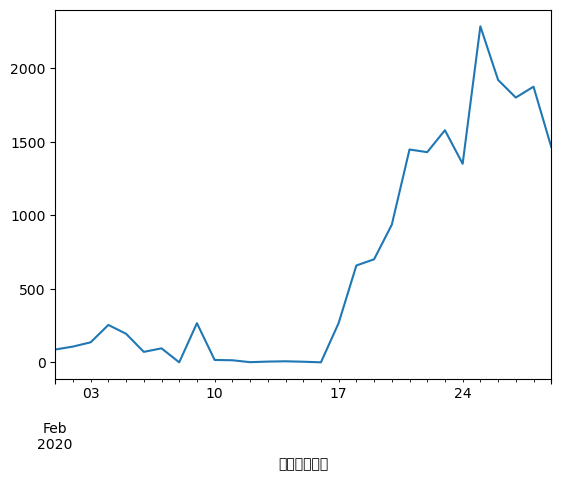

In [41]:
se_trans_month = df_trans.resample('D')['订单编号'].count()
se_trans_month.plot()
se_trans_month.name

In [45]:
from pyecharts.charts import Line

In [46]:
name = 'Orders'

(
    Line()
    .add_xaxis(xaxis_data = list(se_trans_month.index.day.map(str)))
    .add_yaxis(
        series_name= name,
        y_axis= se_trans_month,

    )
    .set_global_opts(
        yaxis_opts = opts.AxisOpts(
            splitline_opts = opts.SplitLineOpts(is_show = True)
        )
    )
    .render_notebook()
)

In [47]:
# Price Per Order
df_trans['买家实际支付金额'].mean()

100.36861777895014

### Regional Sales

<Axes: xlabel='收货地址'>

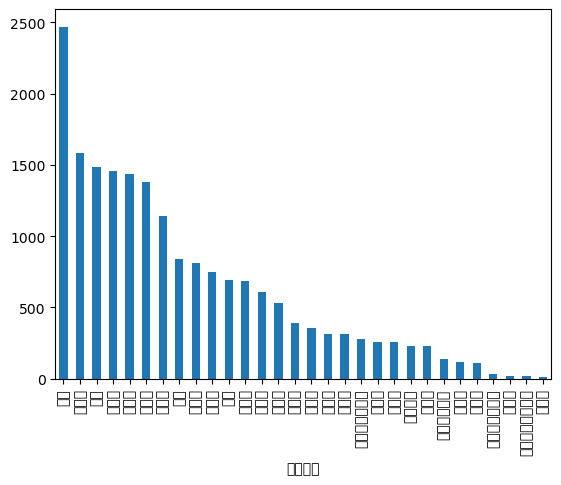

In [48]:
se_trans_map = df_trans.groupby('收货地址')['收货地址'].count().sort_values(ascending = False)
plt.figure(dpi = 100)
se_trans_map.plot(kind = 'bar')
# len(se_trans_map)

In [49]:
def strip_region(iterable):
    result = []
    for i in iterable:
        if i.endswith('自治区'):
            if i == '内蒙古自治区':
                i = i[:3]
                result.append(i)
            else:
                result.append(i[:2])
        else:
            result.append(i)
    return result

In [50]:
se_trans_map.index = strip_region(se_trans_map.index)
se_trans_map.index = se_trans_map.index.str.strip('省')

In [51]:
import pyecharts.options as opts
from pyecharts.charts import Map

In [52]:
# The map
name = 'Orders'

(
    Map()
    .add(
        series_name = name,
        data_pair= [list(i) for i in se_trans_map.items()])
    .set_global_opts(visualmap_opts=opts.VisualMapOpts(
        max_=max(se_trans_map)*0.6
    )
                    )
    .render_notebook()
)


## End of This Analysis